In [79]:
import torch
import matplotlib.pyplot as plt

In [80]:
# Reading the dataset
with open("../data/names.txt", 'r') as file:
    names = [line.strip() for line in file]

names[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [81]:
len(names)

32033

In [82]:
# Bigram model
# Look at one character and predicting the next character in the sequence

bigrams = {} # occurence of bigrams
for name in names:
    # name = '^' + name + '$' # Special characters to indicate start and end of the name
    name = '.' + name + '.'
    for i in range(len(name)-1):
        bigram = name[i:i+2]
        if bigram in bigrams:
            bigrams[bigram] += 1
        else:
            bigrams[bigram] = 1


In [83]:
bigrams

{'.e': 1531,
 'em': 769,
 'mm': 168,
 'ma': 2590,
 'a.': 6640,
 '.o': 394,
 'ol': 619,
 'li': 2480,
 'iv': 269,
 'vi': 911,
 'ia': 2445,
 '.a': 4410,
 'av': 834,
 'va': 642,
 '.i': 591,
 'is': 1316,
 'sa': 1201,
 'ab': 541,
 'be': 655,
 'el': 3248,
 'll': 1345,
 'la': 2623,
 '.s': 2055,
 'so': 531,
 'op': 95,
 'ph': 204,
 'hi': 729,
 '.c': 1542,
 'ch': 664,
 'ha': 2244,
 'ar': 3264,
 'rl': 413,
 'lo': 692,
 'ot': 118,
 'tt': 374,
 'te': 716,
 'e.': 3983,
 '.m': 2538,
 'mi': 1256,
 'am': 1634,
 'me': 818,
 '.h': 874,
 'rp': 14,
 'pe': 197,
 'er': 1958,
 'r.': 1377,
 'ev': 463,
 've': 568,
 'ly': 1588,
 'yn': 1826,
 'n.': 6763,
 'bi': 217,
 'ig': 428,
 'ga': 330,
 'ai': 1650,
 'il': 1345,
 'l.': 1314,
 'y.': 2007,
 'iz': 277,
 'za': 860,
 'et': 580,
 'th': 647,
 'h.': 2409,
 'ry': 773,
 'of': 34,
 'fi': 160,
 'ca': 815,
 'ri': 3033,
 'sc': 60,
 'le': 2921,
 't.': 483,
 '.v': 376,
 'ic': 509,
 'ct': 35,
 'to': 667,
 'or': 1059,
 'ad': 1042,
 'di': 674,
 'on': 2411,
 '.l': 1572,
 'lu': 324

In [84]:
# letters of the alphabet + special characters
letters = [c for c in '.abcdefghijklmnopqrstuvwxyz']

# Convertion between characters and integers
itos = {i: c for i, c in enumerate(letters)}
stoi = {c: i for i, c in enumerate(letters)}

In [85]:
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [86]:
# Array of frequency of bigrams
# Rows are the first character of the bigram
# Columns are the second character of the bigram

bigram_array = torch.zeros(len(letters), len(letters))
for c1 in letters:
    for c2 in letters:
        bigram = c1 + c2
        if bigram in bigrams:
            bigram_array[stoi[c1], stoi[c2]] = bigrams[bigram]

In [87]:
# The loss is infinite if the name contain a pair of characters that is not in the model
# Add a count of 1 to all bigrams

bigram_array += 1

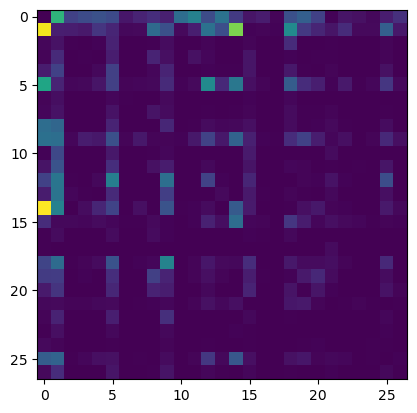

In [88]:
%matplotlib inline
plt.imshow(bigram_array)

(-0.5, 26.5, 26.5, -0.5)

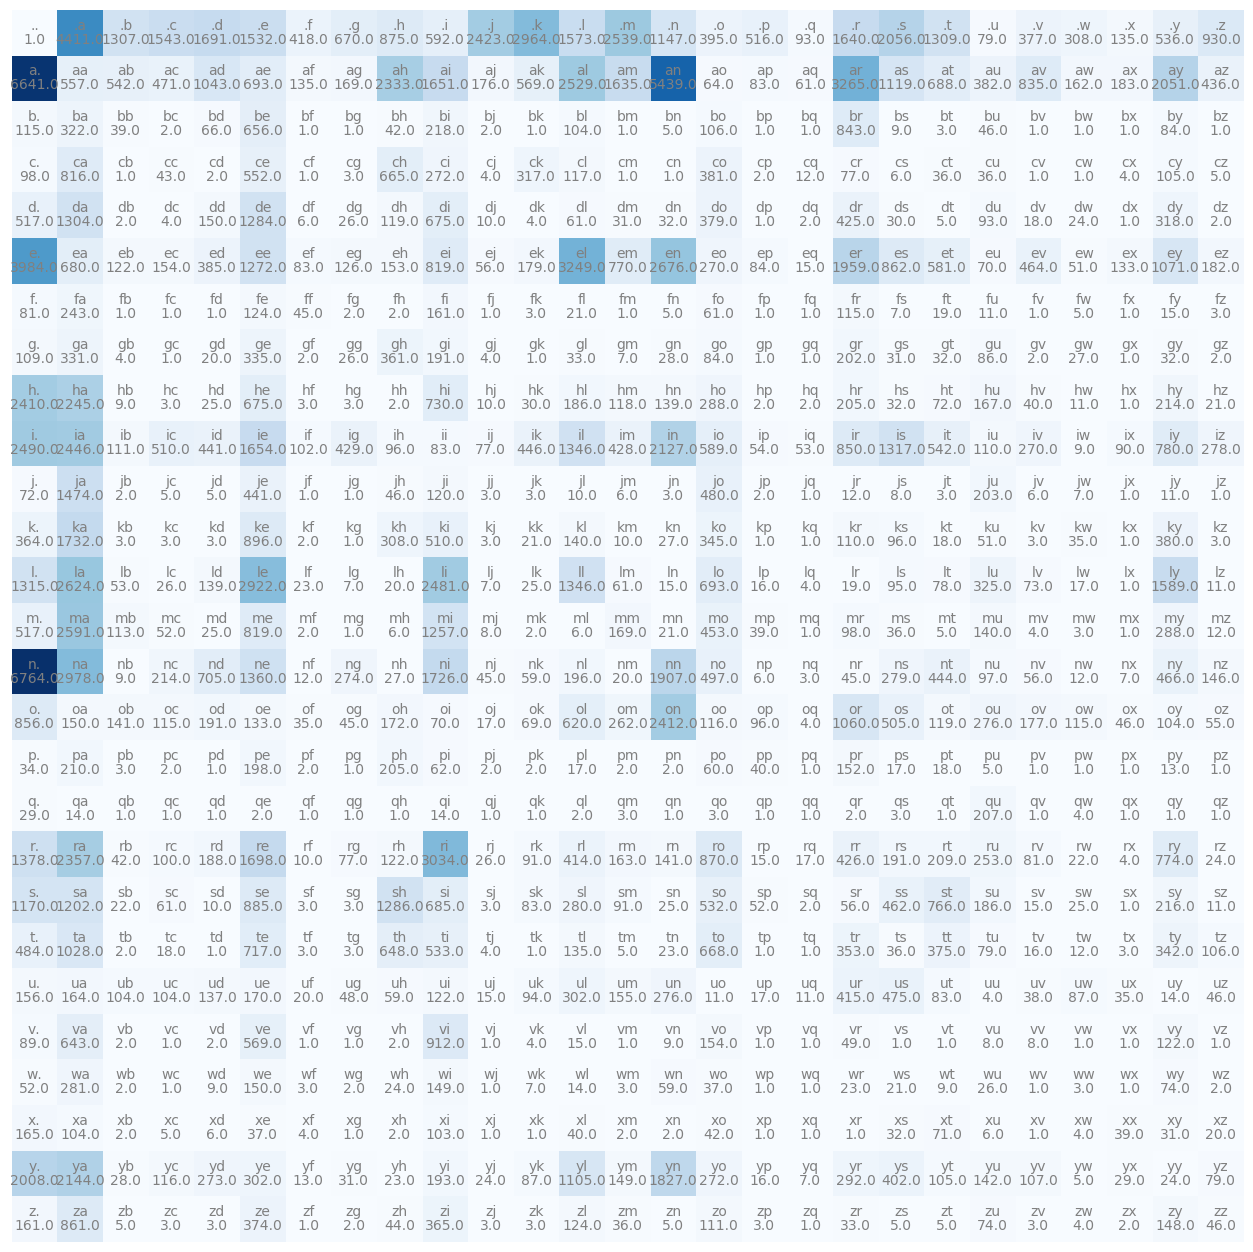

In [89]:
%matplotlib inline
plt.figure(figsize=(16, 16))
plt.imshow(bigram_array, cmap='Blues')
for i in range(len(letters)):
    for j in range(len(letters)):
        bigram = itos[i] + itos[j]
        plt.text(j, i, bigram, ha='center', va='bottom', color='gray')
        plt.text(j, i, bigram_array[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [90]:
# Create probability distribution for each row
probs = bigram_array / bigram_array.sum(dim=1, keepdim=True)

In [91]:
# Set torch seed
torch.manual_seed(42)

In [92]:
# Generate 10 names
for i in range(20):
    c1 = '.'
    c2 = ''
    while c2 != '.':
        c2 = itos[torch.multinomial(probs[stoi[c1]], 1, replacement=True).item()]
        print(c2, end='')
        c1 = c2
    print()

a.
a.
keys.
a.
hmone.
mif.
mah.
ay.
dadabenes.
ely.
jayna.
mena.
lezain.
an.
makhopamya.
m.
kh.
enan.
tyan.
ayn.


## Evaluate the model
Log likelihood is the log of all the probabilities multiplied
to use it like a loss function, the lower it can gets must be zero, so we take the negative of it
the final loss function is the negative log likelihood normalized

### Goal
- Maximize likelihood of the data
- Maximeze the log likelihood
- Minimize the negative log likelihood
- Minimize average negative log likelihood

In [93]:
def calculate_loss(words):
    n = 0
    loglikelihood = 0.0
    for w in words:
        w = ['.'] + list(w) + ['.']
        for c1, c2 in zip(w, w[1:]):
            i1 = stoi[c1]
            i2 = stoi[c2]
            prob = probs[i1, i2] 
            log_prob = torch.log(prob)
            loglikelihood += log_prob
            n += 1
    
    return -loglikelihood / n

In [94]:
calculate_loss(["babs", "baba"])

tensor(3.0283)

## Neural Network
### Training set of bigrams


In [95]:
def build_dataset(names):
    X, Y = [], []

    for name in names:
        c1 = 0
        for ch in name + '.':
            X.append(c1)
            Y.append(stoi[ch])
            c1 = stoi[ch]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


In [96]:
# Spliting dataset
import random
random.seed(42)
random.shuffle(names)

train_size = int(0.8 * len(names))
test_size = int (0.1 * len(names))

Xtrain, Ytrain = build_dataset(names[:train_size])
Xdev, Ydev = build_dataset(names[train_size:train_size+test_size])
Xtest, Ytest = build_dataset(names[train_size+test_size:])


torch.Size([182625]) torch.Size([182625])
torch.Size([22655]) torch.Size([22655])
torch.Size([22866]) torch.Size([22866])


In [97]:
import torch.nn.functional as F

In [98]:
# Since the index does not have any numerical meaning
# apply one hot encode
Xtrain =  F.one_hot(Xtrain, len(letters)).float()
Xdev =  F.one_hot(Xdev, len(letters)).float()
Xtest =  F.one_hot(Xtest, len(letters)).float()



In [99]:
Xtrain.shape

torch.Size([182625, 27])

In [100]:
g = torch.Generator().manual_seed(42)
W = torch.randn((27,27), generator=g, requires_grad=True)


In [118]:
# gradient descent
for epoch in range(100):
  
  # forward pass
  logits = Xtrain @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(len(Ytrain)), Ytrain].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.373884677886963
3.158179759979248
3.015285015106201
2.9186928272247314
2.8480496406555176
2.794994592666626
2.7543184757232666
2.7224721908569336
2.6969735622406006
2.6760997772216797
2.658672571182251
2.643878936767578
2.6311471462249756
2.6200647354125977
2.6103265285491943
2.6017003059387207
2.594005823135376
2.587100028991699
2.5808706283569336
2.575223922729492
2.5700843334198
2.5653886795043945
2.5610837936401367
2.5571250915527344
2.553473472595215
2.550096273422241
2.546964168548584
2.544053077697754
2.5413403511047363
2.5388071537017822
2.5364365577697754
2.5342142581939697
2.5321269035339355
2.530163288116455
2.5283126831054688
2.526566505432129
2.524916648864746
2.523355722427368
2.5218770503997803
2.520475149154663
2.519144296646118
2.5178802013397217
2.5166778564453125
2.515533447265625
2.5144431591033936
2.51340389251709
2.5124125480651855
2.5114660263061523
2.510561466217041
2.5096969604492188
2.5088701248168945
2.508078098297119
2.507319927215576
2.5065927505493164
2.

In [130]:
# Sampling
for i in range(5):
  
  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

ca.
jnasenan.
son.
ahondacenckonoiyaanare.
kiris.
